## Importing libraries

In [ ]:
!pip install opencv-python==4.5.4.58

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.spatial import distance
from numpy import linalg as LA
from PIL import Image
from google.colab.patches import cv2_imshow

## Loading the images in Gray scale to reduce computation

In [ ]:
def get_image_v(path):
  img = cv.imread(path)
  return cv.cvtColor(img, cv.COLOR_RGB2GRAY), cv.cvtColor(img, cv.COLOR_BGR2RGB)

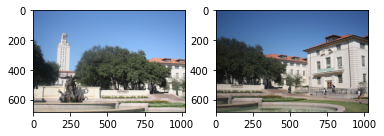

In [ ]:
left_img_gray, left_img_color = get_image_v('./left1.jpg')
right_img_gray, right_img_color = get_image_v('./right1.jpg')
plt.axis('off')
plt.subplot(1, 2, 1)
plt.imshow(left_img_color)
plt.subplot(1, 2, 2)
plt.imshow(right_img_color)
plt.show()

## Sift Detection

In [ ]:
def sift_descriptors(img):
    sift = cv.SIFT_create()
    keypoints, desc = sift.detectAndCompute(img,None)
    return keypoints, desc

In [ ]:
kp_l, desp_l = sift_descriptors(left_img_gray)
kp_r, desp_r = sift_descriptors(right_img_gray)

In [ ]:
def get_matched_pixels(key_points_l, key_points_r, descl, descr, threshold):
    pair_dist = distance.cdist(descl, descr, 'sqeuclidean')
    descl_idx, descr_idx = np.where(pair_dist < threshold)[:2]
    cord1 = np.array([key_points_l[idx].pt for idx in descl_idx])
    cord2 = np.array([key_points_r[idx].pt for idx in descr_idx])
    return np.concatenate((cord1, cord2), axis=1)

In [ ]:
pairs = get_matched_pixels(kp_l, kp_r, desp_l, desp_r, 7000)

In [ ]:
def compute_homogorphy(pairs):
  A = []
  for i in range(len(pairs)):
    xs, ys = pairs[i][:2]
    xd, yd = pairs[i][2:4]
    A.append([0,0,0,xs,ys,1,-yd*xs,-yd*ys, -yd,xs,ys,1,0,0,0,-xd*xs,-xd*ys,-xd])
  A = np.reshape(A, (-1, 9))
  V = np.linalg.svd(A)[2]
  H = V[len(V)-1].reshape(3, 3)
  return H / H[2, 2]

In [ ]:
def compute_errors(pairs, H):
  source_matrix = np.array([np.append(pairs[i][:2], 1) for i in range(len(pairs))]).T
  destn_matrix = pairs[:, 2:4]
  trf_matrix = np.array([row/row[2] for row in (H @ source_matrix).T])[:, :2]
  return np.linalg.norm(destn_matrix - trf_matrix, axis=1) ** 2

In [ ]:
def ransac_fitting(pairs, threshold, iterations=1000):
  best_inliners = []
  best_H = []
  for i in range(iterations):
    selected_pairs = pairs[np.random.choice(len(pairs), 4, False)]
    H = compute_homogorphy(selected_pairs)
    if np.linalg.matrix_rank(H) < 3: continue
    errors = compute_errors(pairs, H)
    loc = np.where(errors < threshold)[0]
    inliners = pairs[loc]
    if len(inliners) > len(best_inliners): 
      best_inliners, best_H = inliners, H
      avg_residual = (errors[loc]/len(best_inliners)).sum()
  return best_inliners, best_H, avg_residual

In [ ]:
 inliers, H, avg_residual = ransac_fitting(pairs, 0.3)
 print('Inliers: ', len(inliers))
 print('Avgerage residual: ', avg_residual)

Inliers:  141
Avgerage residual:  0.09807705165878611


In [ ]:
def plot_inlier_matches(img_left, kp_left, img_right, kp_right, inliers):
    inliers = [cv.DMatch(_imgIdx=0, _queryIdx=i, _trainIdx=i, _distance=0) for i in range(len(inliers))]
    cv_kp1 = [cv.KeyPoint(x=pt[0], y=pt[1], size=1) for pt in kp_left]
    cv_kp2 = [cv.KeyPoint(x=pt[0], y=pt[1], size=1) for pt in kp_right]
    img = cv.drawMatches(img_left, cv_kp1, img_right, cv_kp2, inliers, None)
    fig, ax = plt.subplots(figsize=(20, 11))
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [ ]:
def compare_harris_sift():
  dst = cv.cornerHarris(left_img_gray,2,3,0.04)
  dst = cv.dilate(dst,None)
  img_copy = left_img_color.copy()
  img_copy[dst>0.01*dst.max()]=[0,0,255]
  fig, (a0, a1) = plt.subplots(1, 2, figsize=(20, 11))
  a0.imshow(img_copy)
  a0.axis('off')
  a0.set_title('Harris Detector')
  img_copy = left_img_color.copy()
  img_copy = cv.drawKeypoints(left_img_color, kp_l, img_copy, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)   
  a1.imshow(img_copy)
  a1.axis('off')
  a1.set_title('SIFT Detector')
  plt.show()

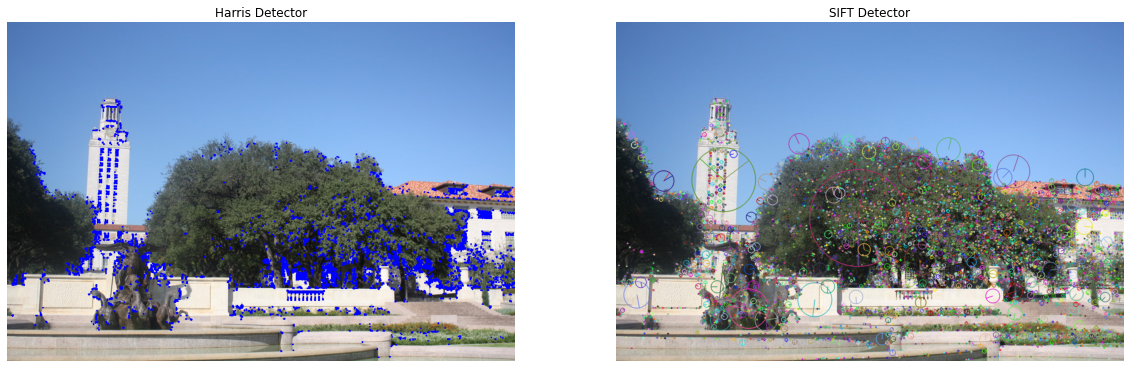

In [ ]:
compare_harris_sift()

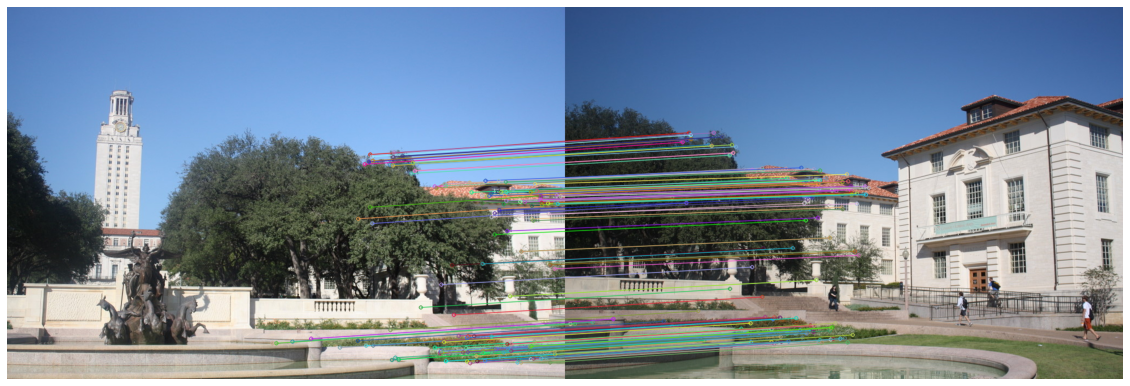

In [ ]:
plot_inlier_matches(left_img_color, inliers[:,:2], right_img_color, inliers[:, 2:4], inliers)

In [ ]:
def warp(img, H):    
    h, w = img.shape[:2]    
    c = [[0, 0], [w, 0], [w, h], [0, h]]
    new_corners = np.array([np.matmul(H, np.append(np.array(c), 1)) for c in c]).T
    x, y = min(new_corners[0] / new_corners[2]), min(new_corners[1] / new_corners[2])
    new_homography = np.dot(np.array([[1, 0, -x], [0, 1, -y], [0, 0, 1]]), H)
    warped_img = cv.warpPerspective(src=img, M=new_homography, dsize=( int(round(abs(x) + w)), int(round(abs(y) + h))))
    return warped_img, (x, y)

def move(img, translation):
    x, y = translation[:2]
    h, w = img.shape[:2]
    M = np.array([[1, 0, -x], [0, 1, -y], [0, 0, 1]])
    return cv.warpPerspective(src=img, M=M, dsize=(int(round(abs(x) + w)), int(round(abs(y) + h))))

def stitch(img_left, img_right, H):
    norm_left = cv.normalize(img_left.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
    norm_right = cv.normalize(img_right.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
    l, translation = warp(norm_left, H)
    r = move(norm_right, translation)
    zeros = np.zeros(3)
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            p_l, p_r = l[i, j, :], r[i, j, :]
            if np.array_equal(p_r, zeros) and not np.array_equal(p_l, zeros): l[i, j, :] = p_l
            elif not np.array_equal(p_r, zeros) and np.array_equal(p_l, zeros): l[i, j, :] = p_r
            elif not np.array_equal(p_r, zeros) and not np.array_equal(p_l, zeros): l[i, j, :] = (p_l + p_r) / 2
    return l[:r.shape[0], :r.shape[1], :]

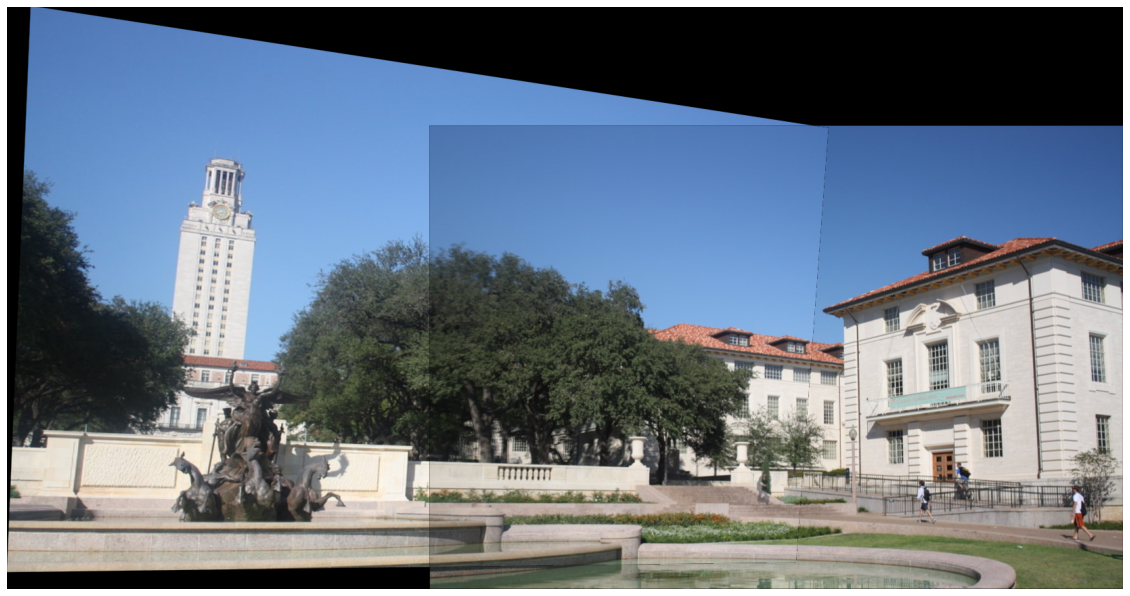

In [ ]:
stitched = stitch(left_img_color, right_img_color, H)
fig, ax = plt.subplots(figsize=(20, 11))
ax.imshow(stitched)
ax.axis('off')
plt.show()